<a href="https://colab.research.google.com/github/muawenkei/smyxrepository/blob/master/Assignment/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Comparative Study of Latest Models for TwitterSentiment Analysis (Assignment2)


In [1]:
# Silent installation 
!pip install -U tensorflow zhon transformers sentencepiece &> /dev/null
# Download dataset and lib files from the github
!git clone https://github.com/cardiffnlp/tweeteval.git &> /dev/null
!git clone https://github.com/gibsonx/grocery.git &> /dev/null

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,confusion_matrix,f1_score

#Import customized classes and libraries from file
sys.path.insert(0, '/content/grocery/')
from CE888_Transformer import DataPrep, imbalance_under_sampling , create_model, get_tokenization, warmup
from CustomizedPlots import *
try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#1.Data nominalization for training , validation and test datasets (Hate, Irony and Offensive)

In [3]:
#Define the root folder where we put the datasets
base_dir = '/content/tweeteval/datasets/'

#Create hate dataframe
hate = DataPrep(base_dir, 'hate') 
hate_dict_train, hate_dict_val, hate_dict_test = hate.dataframe()
df_hate = hate.dataframe_merge()
not_hate, hate = hate.binary_split()

#Create irony dataframe
irony = DataPrep(base_dir, 'irony') 
irony_dict_train, irony_dict_val, irony_dict_test = irony.dataframe()
df_irony = irony.dataframe_merge()
not_irony, irony = irony.binary_split()

#Create offensive dataframe
offensive = DataPrep(base_dir, 'offensive')
offensive_dict_train, offensive_dict_val, offensive_dict_test = offensive.dataframe()
df_offensive = offensive.dataframe_merge()
not_offensive, offensive = offensive.binary_split()

print("The sample of pre-precessed dataset is shown below:")
hate.head()

The sample of pre-precessed dataset is shown below:


,text,label
0,a woman who you fucked multiple times saying y...,1
1,real talk do you have eyes or were they gouge...,1
2,your girlfriend lookin at me like a groupie in...,1
3,i am not going after your ex bf you lieing sac...,1
4,send home migrants not in need of protection p...,1


The samples in the datasets are imbalance, so we make the training dataset balanced using function "imbalance_under_sampling"

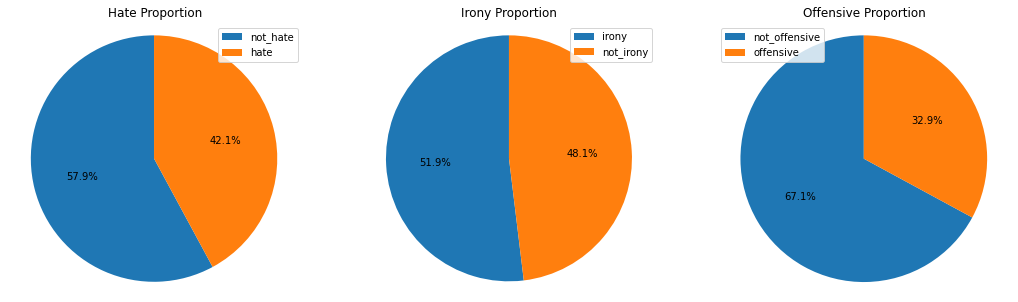

In [4]:
Proportion_chart(df_hate,hate,not_hate,df_irony,irony,not_irony,df_offensive,offensive,not_offensive)

In [5]:
hate_dict_train = imbalance_under_sampling(hate_dict_train)
irony_dict_train = imbalance_under_sampling(irony_dict_train)
offensive_dict_train = imbalance_under_sampling(offensive_dict_train)

#2.Downloading Models and Tokenizations from HuggingFace

In [6]:
from transformers import TFXLNetModel, XLNetTokenizer, TFDistilBertModel, DistilBertTokenizer

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

for layer in xlnet_model.layers:
    layer.trainable = True
for layer in dbert_model.layers:
    layer.trainable = True

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#3.Word Embeddings using XLNet tokenizier, which consist of tokens and attention masks

In [7]:
#DistilBert Tokenizer
dl_hate_train_input = get_tokenization(hate_dict_train['text'], dbert_tokenizer)
dl_hate_val_input = get_tokenization(hate_dict_val['text'], dbert_tokenizer)
dl_hate_test_input = get_tokenization(hate_dict_test['text'], dbert_tokenizer)

dl_irony_train_input = get_tokenization(irony_dict_train['text'], dbert_tokenizer)
dl_irony_val_input = get_tokenization(irony_dict_val['text'], dbert_tokenizer)
dl_irony_test_input = get_tokenization(irony_dict_test['text'], dbert_tokenizer)

dl_offensive_train_input = get_tokenization(offensive_dict_train['text'], dbert_tokenizer)
dl_offensive_val_input = get_tokenization(offensive_dict_val['text'], dbert_tokenizer)
dl_offensive_test_input = get_tokenization(offensive_dict_test['text'], dbert_tokenizer)

#XLNet Tokenizer
xl_hate_train_input = get_tokenization(hate_dict_train['text'], xlnet_tokenizer)
xl_hate_val_input = get_tokenization(hate_dict_val['text'], xlnet_tokenizer)
xl_hate_test_input = get_tokenization(hate_dict_test['text'], xlnet_tokenizer)

xl_irony_train_input = get_tokenization(irony_dict_train['text'], xlnet_tokenizer)
xl_irony_val_input = get_tokenization(irony_dict_val['text'], xlnet_tokenizer)
xl_irony_test_input = get_tokenization(irony_dict_test['text'], xlnet_tokenizer)

xl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
xl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
xl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

#4.Apply DistilBert as the 1st model to predict classifcation.


4.1 DistilBert for Hate Dataset

In [8]:
DistilBert_hate = create_model(dbert_model)
DistilBert_hate.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Set callBacks for all attempts of training

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [10]:
hist_dl_hate = DistilBert_hate.fit(x=dl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 103s 202ms/step - loss: 0.5527 - accuracy: 0.7108 - precision: 0.7036 - recall: 0.7285 - val_loss: 0.5819 - val_accuracy: 0.7010 - val_precision: 0.6190 - val_recall: 0.7799
Epoch 2/25
473/473 [==============================] - 97s 206ms/step - loss: 0.3936 - accuracy: 0.8246 - precision: 0.8107 - recall: 0.8469 - val_loss: 0.5390 - val_accuracy: 0.7270 - val_precision: 0.6774 - val_recall: 0.6885
Epoch 3/25
473/473 [==============================] - 99s 209ms/step - loss: 0.2408 - accuracy: 0.9071 - precision: 0.8981 - recall: 0.9183 - val_loss: 0.7538 - val_accuracy: 0.7040 - val_precision: 0.6131 - val_recall: 0.8314
Epoch 4/25
473/473 [==============================] - 99s 209ms/step - loss: 0.1175 - accuracy: 0.9573 - precision: 0.9555 - recall: 0.9593 - val_loss: 0.7943 - val_accuracy: 0.7310 - val_precision: 0.6660 - val_recall: 0.7424
Epoch 5/25
473/473 [==============================] - 99s 208ms/step - loss: 0.0650 - accur

In [11]:
preds_dl_hate = DistilBert_hate.predict(dl_hate_test_input, verbose=True)

93/93 [==============================] - 13s 124ms/step


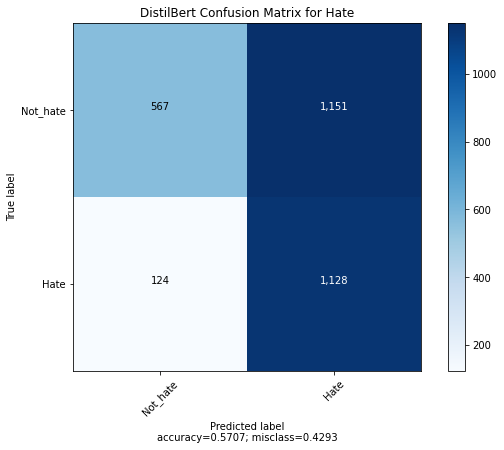

In [12]:
hate_pred_dl_label = [i[0] for i in preds_dl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_dl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="DistilBert Confusion Matrix for Hate")

In [13]:
f1_dl_hate = f1_score(hate_dict_test.label,hate_pred_dl_label,average='macro')
print("F1_score of Hate dataset with DistilBert is: %.1f%%" % round(f1_dl_hate*100,1))

F1_score of Hate dataset with DistilBert is: 55.5%


4.2 DistilBert for Irony Dataset

In [14]:
DistilBert_irony = create_model(dbert_model)
hist_irony = DistilBert_irony.fit(x=dl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


178/178 [==============================] - 48s 232ms/step - loss: 0.6940 - accuracy: 0.5614 - precision_1: 0.5602 - recall_1: 0.5709 - val_loss: 0.6834 - val_accuracy: 0.5654 - val_precision_1: 0.5284 - val_recall_1: 0.8377
Epoch 2/25
178/178 [==============================] - 39s 219ms/step - loss: 0.5569 - accuracy: 0.7191 - precision_1: 0.7122 - recall_1: 0.7354 - val_loss: 0.6619 - val_accuracy: 0.6335 - val_precision_1: 0.6137 - val_recall_1: 0.6272
Epoch 3/25
178/178 [==============================] - 39s 220ms/step - loss: 0.3467 - accuracy: 0.8557 - precision_1: 0.8663 - recall_1: 0.8412 - val_loss: 0.7816 - val_accuracy: 0.6241 - val_precision_1: 0.5821 - val_recall_1: 0.7544
Epoch 4/25
178/178 [==============================] - 39s 220ms/step - loss: 0.1503 - accuracy: 0.9457 - precision_1: 0.9514 - recall_1: 0.9393 - val_loss: 0.9984 - val_accuracy: 0.6325 - val_precision_1: 0.5854 - val_recall_1: 0.7895
Epoch 5/25
178/178 [==============================] - 39s 220ms/step - 

In [15]:
preds_dl_irony = DistilBert_irony.predict(dl_irony_test_input, verbose=True)

25/25 [==============================] - 4s 123ms/step


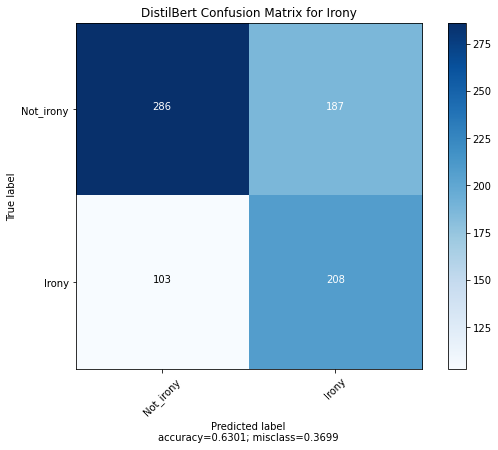

In [16]:
irony_pred_dl_label = [i[0] for i in preds_dl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_dl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="DistilBert Confusion Matrix for Irony")

In [17]:
f1_dl_irony = f1_score(irony_dict_test.label,irony_pred_dl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_dl_irony*100,1))

F1_score of irony dataset with DistilBert is: 62.6%


4.3 DistilBert for Offensive Dataset

In [18]:
DistilBert_offensive = create_model(dbert_model)
hist_dl_offensive = DistilBert_offensive.fit(x=dl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


493/493 [==============================] - 112s 213ms/step - loss: 0.5704 - accuracy: 0.7063 - precision_2: 0.7025 - recall_2: 0.7156 - val_loss: 0.4715 - val_accuracy: 0.7787 - val_precision_2: 0.6701 - val_recall_2: 0.7124
Epoch 2/25
493/493 [==============================] - 104s 210ms/step - loss: 0.4166 - accuracy: 0.8120 - precision_2: 0.8175 - recall_2: 0.8033 - val_loss: 0.5436 - val_accuracy: 0.7628 - val_precision_2: 0.6256 - val_recall_2: 0.7865
Epoch 3/25
493/493 [==============================] - 104s 211ms/step - loss: 0.2739 - accuracy: 0.8839 - precision_2: 0.8836 - recall_2: 0.8843 - val_loss: 0.5640 - val_accuracy: 0.7598 - val_precision_2: 0.6279 - val_recall_2: 0.7538
Epoch 4/25
493/493 [==============================] - 104s 210ms/step - loss: 0.1328 - accuracy: 0.9501 - precision_2: 0.9482 - recall_2: 0.9523 - val_loss: 0.8044 - val_accuracy: 0.7523 - val_precision_2: 0.6313 - val_recall_2: 0.6863
Epoch 5/25
493/493 [==============================] - 104s 210ms/st

In [19]:
preds_dl_offensive = DistilBert_offensive.predict(dl_offensive_test_input, verbose=True)

27/27 [==============================] - 5s 125ms/step


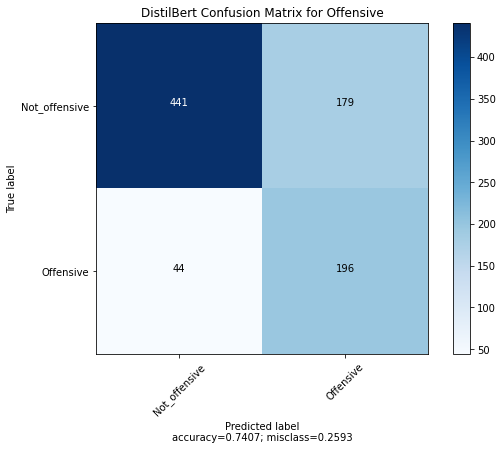

In [20]:
offensive_pred_dl_label = [i[0] for i in preds_dl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_dl_label)
plot_confusion_matrix(cm, normalize=False, target_names=['Not_offensive', 'Offensive'],title="DistilBert Confusion Matrix for Offensive")

In [21]:
f1_dl_offensive = f1_score(offensive_dict_test.label,offensive_pred_dl_label,average='macro')
print("F1_score of offensive dataset with DistilBert is: %.1f%%" % round(f1_dl_offensive*100,1))

F1_score of offensive dataset with DistilBert is: 71.8%


#5. Apply XLNet as the 2nd model to predict classifcation.

5.1 XLnet for Hate Dataset

In [22]:
XLNet_hate = create_model(xlnet_model)
XLNet_hate.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ids (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
word_attention (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model (TFXLNetModel)   TFXLNetModelOutput(l 116718336   word_ids[0][0]                   
                                                                 word_attention[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 1, 768)       0           tfxl_net_model[0][0]       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
hist_xl_hate = XLNet_hate.fit(x=xl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 258s 519ms/step - loss: 0.6448 - accuracy: 0.6420 - precision_3: 0.6418 - recall_3: 0.6426 - val_loss: 0.6155 - val_accuracy: 0.6790 - val_precision_3: 0.6113 - val_recall_3: 0.6815
Epoch 2/25
473/473 [==============================] - 243s 513ms/step - loss: 0.5193 - accuracy: 0.7417 - precision_3: 0.7320 - recall_3: 0.7626 - val_loss: 0.5703 - val_accuracy: 0.6950 - val_precision_3: 0.6138 - val_recall_3: 0.7705
Epoch 3/25
473/473 [==============================] - 243s 513ms/step - loss: 0.4367 - accuracy: 0.8053 - precision_3: 0.7902 - recall_3: 0.8314 - val_loss: 0.5868 - val_accuracy: 0.7180 - val_precision_3: 0.6392 - val_recall_3: 0.7799
Epoch 4/25
473/473 [==============================] - 243s 513ms/step - loss: 0.3445 - accuracy: 0.8545 - precision_3: 0.8474 - recall_3: 0.8647 - val_loss: 0.6146 - val_accuracy: 0.7030 - val_precision_3: 0.6280 - val_recall_3: 0.7471
Epoch 5/25
473/473 [==============================] - 24

In [24]:
preds_xl_hate = XLNet_hate.predict(xl_hate_test_input, verbose=True)

93/93 [==============================] - 32s 324ms/step


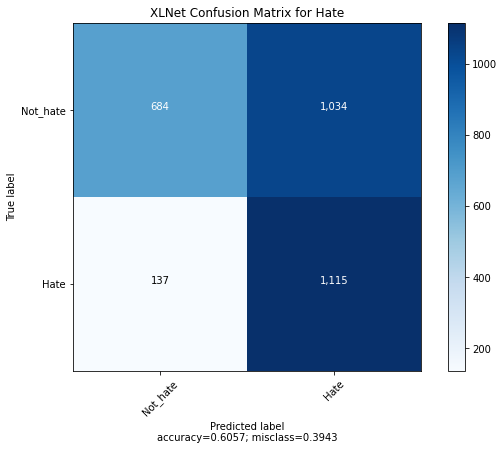

In [25]:
hate_pred_xl_label = [i[0] for i in preds_xl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="XLNet Confusion Matrix for Hate")

In [26]:
f1_xl_hate = f1_score(hate_dict_test.label,hate_pred_xl_label,average='macro')
print("F1_score of Hate dataset with XLnet is: %.1f%%" % round(f1_xl_hate*100,1))

F1_score of Hate dataset with XLnet is: 59.7%


XLnet for Irony Dataset

In [27]:
XLNet_irony = create_model(xlnet_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
hist_xl_irony = XLNet_irony.fit(x=xl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 96s 542ms/step - loss: 0.0728 - accuracy: 0.9795 - precision_4: 0.9809 - recall_4: 0.9781 - val_loss: 2.3051 - val_accuracy: 0.6398 - val_precision_4: 0.6315 - val_recall_4: 0.5899
Epoch 2/25
178/178 [==============================] - 96s 542ms/step - loss: 0.0499 - accuracy: 0.9880 - precision_4: 0.9908 - recall_4: 0.9852 - val_loss: 2.0957 - val_accuracy: 0.6555 - val_precision_4: 0.6267 - val_recall_4: 0.6886
Epoch 3/25
178/178 [==============================] - 96s 541ms/step - loss: 0.0330 - accuracy: 0.9894 - precision_4: 0.9922 - recall_4: 0.9866 - val_loss: 2.2799 - val_accuracy: 0.6513 - val_precision_4: 0.6108 - val_recall_4: 0.7434
Epoch 4/25
178/178 [==============================] - 96s 540ms/step - loss: 0.0347 - accuracy: 0.9894 - precision_4: 0.9922 - recall_4: 0.9866 - val_loss: 3.0141 - val_accuracy: 0.6325 - val_precision_4: 0.5910 - val_recall_4: 0.7478
Epoch 5/25
178/178 [==============================] - 96s 54

In [29]:
preds_xl_irony = XLNet_irony.predict(xl_irony_test_input, verbose=True)

25/25 [==============================] - 10s 310ms/step


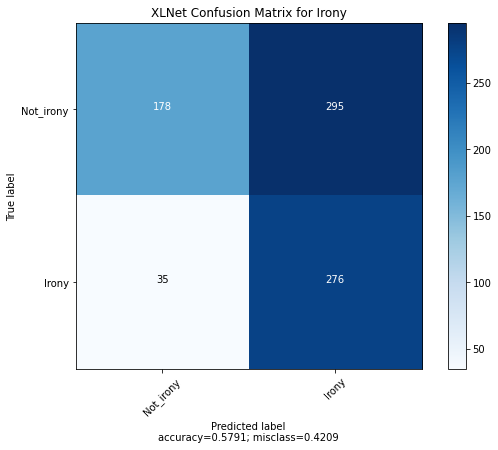

In [30]:
irony_pred_xl_label = [i[0] for i in preds_xl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="XLNet Confusion Matrix for Irony")

In [31]:
f1_xl_irony = f1_score(irony_dict_test.label,irony_pred_xl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_xl_irony * 100,1))

F1_score of irony dataset with DistilBert is: 57.2%


5.3 XLnet for Offensive Dataset

In [32]:
XLNet_offensive = create_model(xlnet_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
hist_xl_offensive = XLNet_offensive.fit(x=xl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 258s 524ms/step - loss: 0.4861 - accuracy: 0.7706 - precision_5: 0.7627 - recall_5: 0.7856 - val_loss: 0.5324 - val_accuracy: 0.7583 - val_precision_5: 0.6168 - val_recall_5: 0.7996
Epoch 2/25
493/493 [==============================] - 256s 520ms/step - loss: 0.3567 - accuracy: 0.8474 - precision_5: 0.8429 - recall_5: 0.8538 - val_loss: 0.5004 - val_accuracy: 0.7825 - val_precision_5: 0.6734 - val_recall_5: 0.7233
Epoch 3/25
493/493 [==============================] - 256s 519ms/step - loss: 0.2514 - accuracy: 0.9045 - precision_5: 0.9009 - recall_5: 0.9089 - val_loss: 0.6389 - val_accuracy: 0.7485 - val_precision_5: 0.6079 - val_recall_5: 0.7734
Epoch 4/25
493/493 [==============================] - 256s 520ms/step - loss: 0.1610 - accuracy: 0.9416 - precision_5: 0.9396 - recall_5: 0.9439 - val_loss: 0.9623 - val_accuracy: 0.7462 - val_precision_5: 0.6062 - val_recall_5: 0.7647
Epoch 5/25
493/493 [==============================] - 25

KeyboardInterrupt: ignored

In [ ]:
preds_xl_offensive = XLNet_offensive.predict(xl_offensive_test_input, verbose=True)

In [ ]:
offensive_pred_xl_label = [i[0] for i in preds_xl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="XLNet Confusion Matrix for Offensive")

In [ ]:
f1_xl_offensive = f1_score(offensive_dict_test.label,offensive_pred_xl_label,average='macro')
print("F1_score of offensive dataset with XLNet is: %.1f%%" % round(f1_xl_offensive * 100,1))

#6. Graphs for comparing the result

6.1 Comparasion For Macro F1 score 

In [ ]:
f1_score_bar(f1_dl_hate,f1_dl_irony,f1_dl_offensive,f1_xl_hate,f1_xl_irony,f1_xl_offensive)    

6.2 AUC Performance

In [ ]:
auc_plot_metrics(preds_dl_hate, preds_xl_hate, hate_dict_test.label,
         preds_dl_irony, preds_xl_irony, irony_dict_test.label,
         preds_dl_offensive, preds_xl_offensive, offensive_dict_test.label)